In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* `Importing Modules`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from PIL import Image
import numpy as np
import os

# from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from scipy import linalg
from torchvision import models
from torch import optim
import scipy.io as sio
from tqdm import tqdm
from scipy.ndimage import zoom
import glob
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.inception import inception_v3, Inception_V3_Weights
import uuid

COVER_DIR_TRAIN = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "BSDS500", "images", "train" )
COVER_DIR_TEST = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "BSDS500", "images", "test")
COVER_DIR_VAL = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "BSDS500", "images", "val" )
EDGE_DIR_TRAIN = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "data", "jpg_edge_images", "train")

EDGE_DIR_OUTPUT = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "data", "rcf_predictions")
EDGE_DIR_OUTPUT_2 = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "data", "jpg_edge_images")

# Model weights
CHECKPOINT_DIR = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "artifacts")
DATA_DIR = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography", "data")


CNN_PATH_NEW = os.path.join(CHECKPOINT_DIR, "best_model_new.pth")


# CNN results paths
RCF_RESULTS = os.path.join(DATA_DIR,  "rcf_results")
STEGO_DIR = os.path.join(RCF_RESULTS, "CNN_stego")
DECODED_DIR = os.path.join(RCF_RESULTS, "CNN_decoded")
STEGO_DIR_2 = os.path.join(RCF_RESULTS, "CNN_stego_2")
DECODED_DIR_2 = os.path.join(RCF_RESULTS, "CNN_decoded_2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


* `Creating Dataset`

In [ ]:
class BSDImageNetDataset(Dataset):
    def __init__(self, cover_dir, secret_dir, edge_dir, limit=None, rgb_transform=None, edge_transform=None, val=False):
        self.cover_dir = cover_dir
        self.secret_dir = secret_dir
        self.edge_dir = edge_dir
        self.rgb_transform = rgb_transform
        self.edge_transform = edge_transform

        valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp')
        self.cover_images = sorted([f for f in os.listdir(cover_dir) if f.lower().endswith(valid_extensions)])
        self.secret_images = sorted([f for f in os.listdir(secret_dir) if f.lower().endswith(valid_extensions)])
        self.edge_images = sorted([f for f in os.listdir(edge_dir) if f.lower().endswith(valid_extensions)])

        # Find common image filenames between cover and edge (based on filename without extension)
        cover_names = set([os.path.splitext(f)[0] for f in self.cover_images])
        edge_names = set([os.path.splitext(f)[0] for f in self.edge_images])

        # Get common names between cover and edge directories only
        common_names = list(cover_names.intersection(edge_names))
        common_names.sort()  # Sort for consistency

        # Limit the number of images if specified
        if limit is not None and limit < len(common_names):
            common_names = common_names[:limit]

        # Create filtered lists for cover and edge images
        self.cover_images = [f for f in self.cover_images if os.path.splitext(f)[0] in common_names]
        self.edge_images = [f for f in self.edge_images if os.path.splitext(f)[0] in common_names]

        # For secret images, just take the first 'limit' or use all if no limit
        if limit is not None and limit < len(self.secret_images) and val:
            self.secret_images = self.secret_images[:-limit-1:-1]
        elif limit is not None and limit < len(self.secret_images):
            self.secret_images = self.secret_images[:limit]
        else:
            self.secret_images = self.secret_images[:len(self.cover_images)]

        # Make sure we have exactly the same number of images now
        assert len(self.cover_images) == len(self.secret_images) == len(self.edge_images), \
            f"Failed to match images across directories: cover={len(self.cover_images)}, secret={len(self.secret_images)}, edge={len(self.edge_images)}"

        print(f"Dataset created with {len(self.cover_images)} images (limit={limit})")

    def __len__(self):
        return len(self.cover_images)

    def __getitem__(self, idx):
        cover_path = os.path.join(self.cover_dir, self.cover_images[idx])
        secret_path = os.path.join(self.secret_dir, self.secret_images[idx])
        edge_path = os.path.join(self.edge_dir, self.edge_images[idx])
        cover_name = os.path.basename(cover_path).replace(".jpg", "")

        try:
            cover = Image.open(cover_path).convert('RGB')
            secret = Image.open(secret_path).convert('RGB')
            edge = Image.open(edge_path).convert('L')
        except Exception as e:
            raise RuntimeError(f"Failed to load image at index {idx}: {e}\n"
                              f"Cover: {cover_path}\nSecret: {secret_path}\nEdge: {edge_path}")

        if self.rgb_transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            cover = self.rgb_transform(cover)
            torch.manual_seed(seed)
            secret = self.rgb_transform(secret)
        if self.edge_transform:
            torch.manual_seed(seed)
            edge = self.edge_transform(edge)

        edge = (edge > 0.12).float()  # Binary threshold
        # edge = F.max_pool2d(edge, kernel_size=3, stride=1, padding=1)  # Dilate edges

        return cover, secret, edge, cover_name

* `Building network`

In [ ]:
class HideNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Secret Image Encoder (multi-scale features)
        self.secret_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.GroupNorm(8, 32),  # Replace BatchNorm2d
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(16, 64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.GroupNorm(32, 128),
            nn.LeakyReLU(0.2)
        )

        # Edge-Aware Fusion Module
        self.fusion = nn.Sequential(
            nn.Conv2d(128 + 3 + 1, 256, 3, padding=1),  # secret_feat + cover + edge
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.GroupNorm(32, 128),
            nn.LeakyReLU(0.2)
        )

        # Edge-Constrained Decoder (no upsampling, fixed from previous issue)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.GroupNorm(16, 64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, cover, secret, edge_map):
        # 1. Extract multi-scale secret features
        secret_feat = self.secret_encoder(secret)  # (B, 128, H/4, W/4)
        secret_feat_up = F.interpolate(secret_feat, size=(cover.shape[2], cover.shape[3]), mode='bilinear', align_corners=False)

        # 2. Edge-guided fusion
        x = torch.cat([cover, edge_map, secret_feat_up], dim=1)
        fused = self.fusion(x)

        # 3. Generate edge-constrained modifications
        delta = self.decoder(fused)

        # 4. Strict edge masking
        edge_mask = edge_map.repeat(1, 3, 1, 1)
        stego = cover + delta * edge_mask

        # Return stego and intermediate features for skip connections
        return stego, secret_feat, fused

class RevealNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: stego (3 channels) + edge_map (1 channel) + skip connections (128 from secret_feat + 128 from fused)
        self.net = nn.Sequential(
            nn.Conv2d(3 + 1 + 128 + 128, 256, 3, padding=1),  # Combine stego, edge_map, secret_feat, fused
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.GroupNorm(32, 128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.GroupNorm(16, 64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, stego, edge_map, secret_feat, fused):
        # Upsample secret_feat to match stego dimensions
        secret_feat = F.interpolate(secret_feat, size=(stego.shape[2], stego.shape[3]), mode='bilinear', align_corners=False)
        # Concatenate inputs
        x = torch.cat([stego, edge_map, secret_feat, fused], dim=1)
        return self.net(x)

class SteganoModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hide_network = HideNetwork()
        self.reveal_network = RevealNetwork()

    def forward(self, cover, secret, edge_map):
        stego, secret_feat, fused = self.hide_network(cover, secret, edge_map)
        recovered_secret = self.reveal_network(stego, edge_map, secret_feat, fused)
        return stego, recovered_secret

In [ ]:
def load_checkpoint(checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    try:
        # Initialize the model
        model = SteganoModel()

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load state dict into the model
        model.load_state_dict(checkpoint)

        # Move model to the specified device
        model = model.to(device)

        # Set model to evaluation mode (can be changed to train mode if needed)
        model.eval()

        print(f"Successfully loaded checkpoint from {checkpoint_path} to {device}")
        return model

    except FileNotFoundError:
        raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")
    except RuntimeError as e:
        raise RuntimeError(f"Error loading checkpoint: {str(e)}. Ensure the model architecture matches the checkpoint.")
    except Exception as e:
        raise Exception(f"Unexpected error while loading checkpoint: {str(e)}")

# Load the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_checkpoint(CNN_PATH_NEW, device)

Successfully loaded checkpoint from /content/drive/MyDrive/image steganography/artifacts/best_model_new.pth to cpu


* `Create dataloaders`

In [ ]:
# Create directories if they don't exist
os.makedirs(STEGO_DIR_2, exist_ok=True)
os.makedirs(DECODED_DIR_2, exist_ok=True)

rgb_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
edge_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset
# dataset = StegoDataset(COVER_DIR, SECRET_DIR2, EDGE_DIR_OUTPUT,
#                         rgb_transform=transform, edge_transform=transform, limit=4000)
dataset = BSDImageNetDataset(
        cover_dir=COVER_DIR_TRAIN,
        secret_dir=COVER_DIR_TEST,
        edge_dir=EDGE_DIR_OUTPUT_6,
        limit=200,
        rgb_transform=rgb_transform,
        edge_transform=edge_transform,
    )

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

print(f"Number of samples in dataset: {len(dataset)}")

Dataset created with 200 images (limit=200)
Number of samples in dataset: 200


* `Inference`

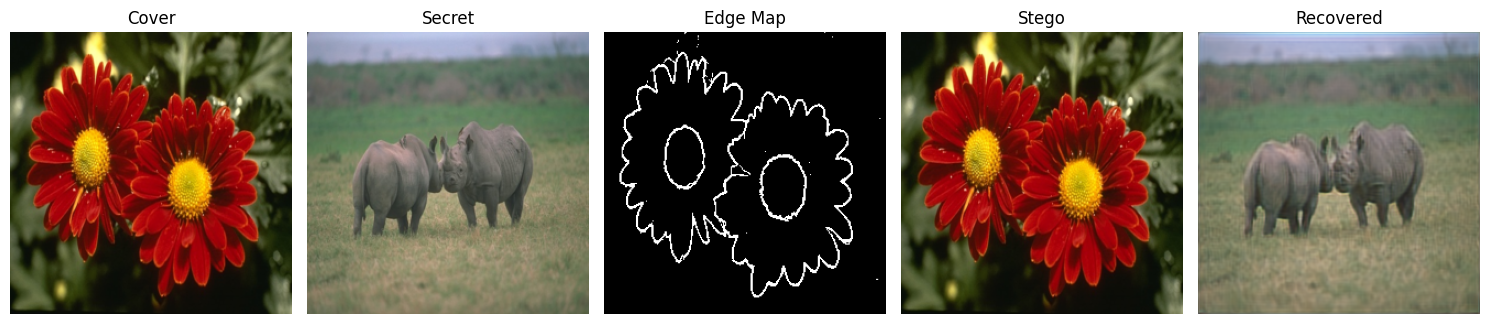

In [ ]:
# Example: Test with a single batch from the validation loader
from torch.utils.data import DataLoader
# Assuming val_loader is defined
model.eval()
with torch.no_grad():
    cover, secret, edge_map, _ = next(iter(dataloader))
    cover, secret, edge_map = cover.to(device), secret.to(device), edge_map.to(device)
    stego, recovered_secret = model(cover, secret, edge_map)

    # Visualize results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    titles = ["Cover", "Secret", "Edge Map", "Stego", "Recovered"]
    images = [
        cover[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
        secret[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
        edge_map[0].cpu().squeeze(),
        stego[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
        recovered_secret[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
    ]

    for i in range(len(titles)):
        plt.subplot(1, len(titles), i + 1)
        if i == 2:  # Edge map is grayscale
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
def run_inference(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Runs inference on the entire dataset and saves stego and recovered secret images.

    Args:
        model: The loaded SteganoModel
        dataloader: DataLoader containing the dataset
        output_dir (str): Base directory to save results
        device (str): Device to run inference on
    """
    import os
    from PIL import Image
    import numpy as np
    from tqdm import tqdm


    os.makedirs(STEGO_DIR, exist_ok=True)
    os.makedirs(DECODED_DIR, exist_ok=True)

    model.eval()

    def tensor_to_image(tensor):
        """Convert normalized tensor to PIL Image"""
        # Denormalize: tensor is in range [-1, 1], convert to [0, 1]
        tensor = tensor * 0.5 + 0.5
        # Clamp values to [0, 1]
        tensor = torch.clamp(tensor, 0, 1)
        # Convert to numpy and transpose from CHW to HWC
        numpy_img = tensor.cpu().numpy().transpose(1, 2, 0)
        # Convert to uint8
        numpy_img = (numpy_img * 255).astype(np.uint8)
        return Image.fromarray(numpy_img)

    print(f"Starting inference on {len(dataloader)} batches...")

    total_processed = 0

    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(dataloader, desc="Processing batches")):
            # Unpack batch data
            if len(batch_data) == 4:
                cover, secret, edge_map, filenames = batch_data
            else:
                cover, secret, edge_map = batch_data

            # Move to device
            cover = cover.to(device)
            secret = secret.to(device)
            edge_map = edge_map.to(device)

            # Run inference
            stego, recovered_secret = model(cover, secret, edge_map)

            # Process each image in the batch
            batch_size = cover.size(0)
            for i in range(batch_size):
                img_idx = total_processed + i

                # Convert tensors to PIL Images
                stego_img = tensor_to_image(stego[i])
                recovered_img = tensor_to_image(recovered_secret[i])

                # Save images
                stego_filename = f"stego_{filenames[i]}.png"
                recovered_filename = f"recovered_{filenames[i]}.png"

                stego_img.save(os.path.join(STEGO_DIR, stego_filename))
                recovered_img.save(os.path.join(DECODED_DIR, recovered_filename))

            total_processed += batch_size

    print(f"Inference completed! Processed {total_processed} images.")
    print(f"Stego images saved to: {STEGO_DIR}")
    print(f"Recovered secrets saved to: {DECODED_DIR}")

In [ ]:
run_inference(model, dataloader)

Starting inference on 13 batches...


Processing batches: 100%|██████████| 13/13 [19:16<00:00, 88.96s/it]

Inference completed! Processed 200 images.
Stego images saved to: /content/drive/MyDrive/image steganography/data/rcf_results/CNN_stego
Recovered secrets saved to: /content/drive/MyDrive/image steganography/data/rcf_results/CNN_decoded


In [ ]:
# Example: Test with a single batch from the validation loader
from torch.utils.data import DataLoader
def test_inference(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Assuming val_loader is defined
    model.eval()
    with torch.no_grad():
        cover, secret, edge_map, _ = next(iter(dataloader))
        cover, secret, edge_map = cover.to(device), secret.to(device), edge_map.to(device)
        stego, recovered_secret = model(cover, secret, edge_map)

        # Visualize results
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15, 5))
        titles = ["Cover", "Secret", "Edge Map", "Stego", "Recovered"]
        images = [
            cover[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
            secret[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
            edge_map[0].cpu().squeeze(),
            stego[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
            recovered_secret[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
        ]

        for i in range(len(titles)):
            plt.subplot(1, len(titles), i + 1)
            if i == 2:  # Edge map is grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# HED

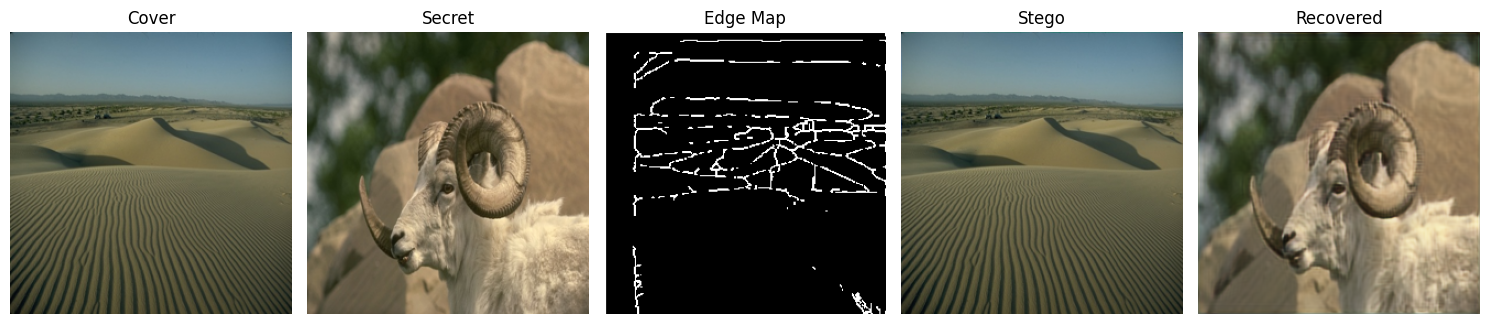

In [ ]:
test_inference(model, dataloader)

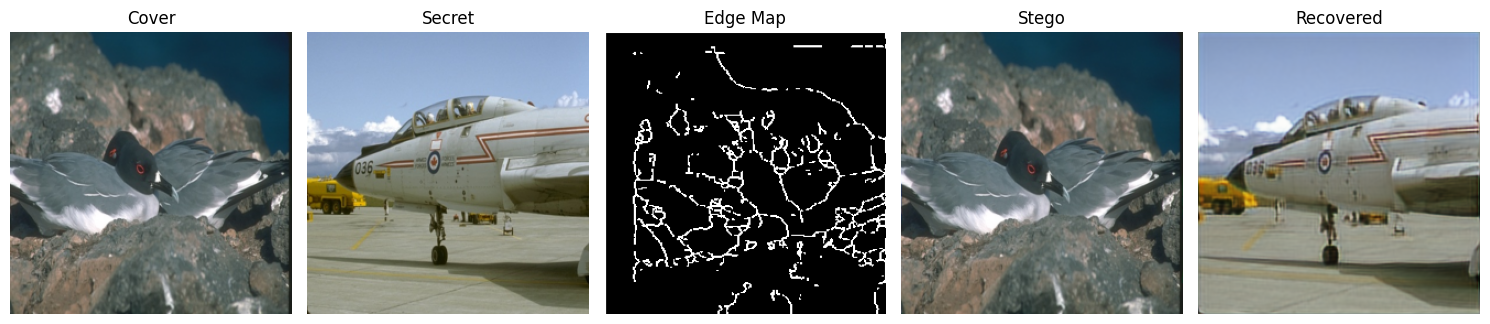

In [ ]:
test_inference(model, dataloader)

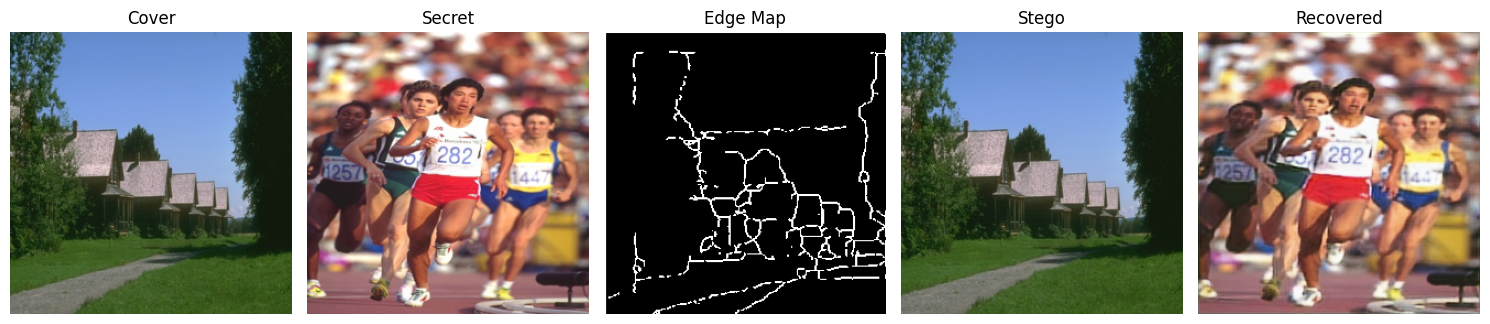

In [ ]:
test_inference(model, dataloader)

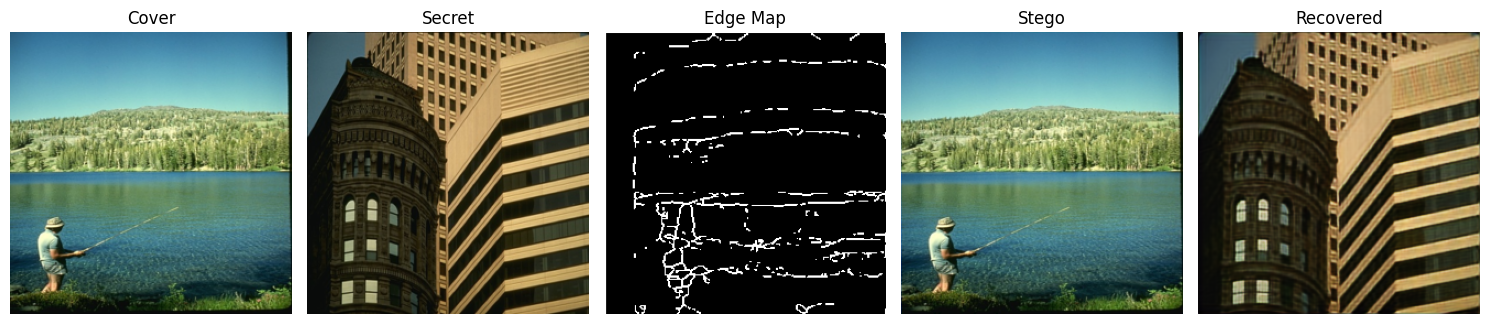

In [ ]:
test_inference(model, dataloader)

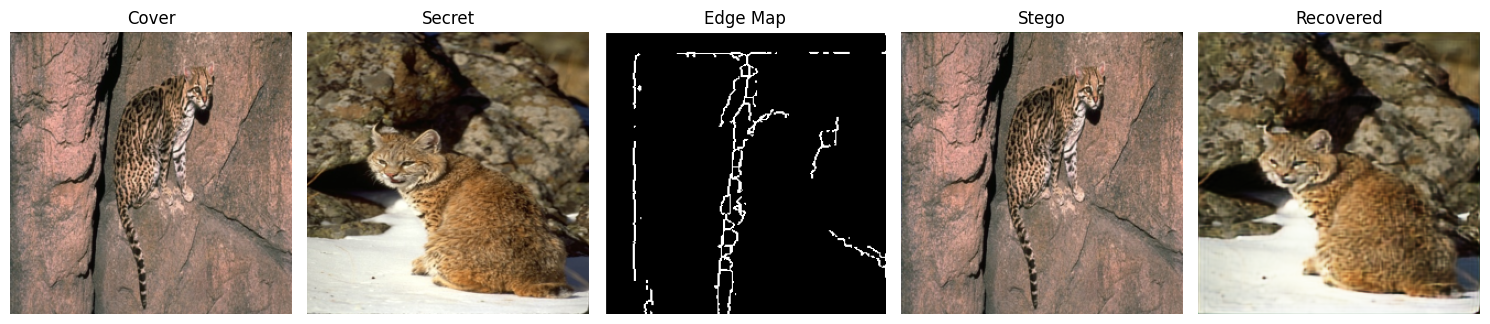

In [ ]:
test_inference(model, dataloader)

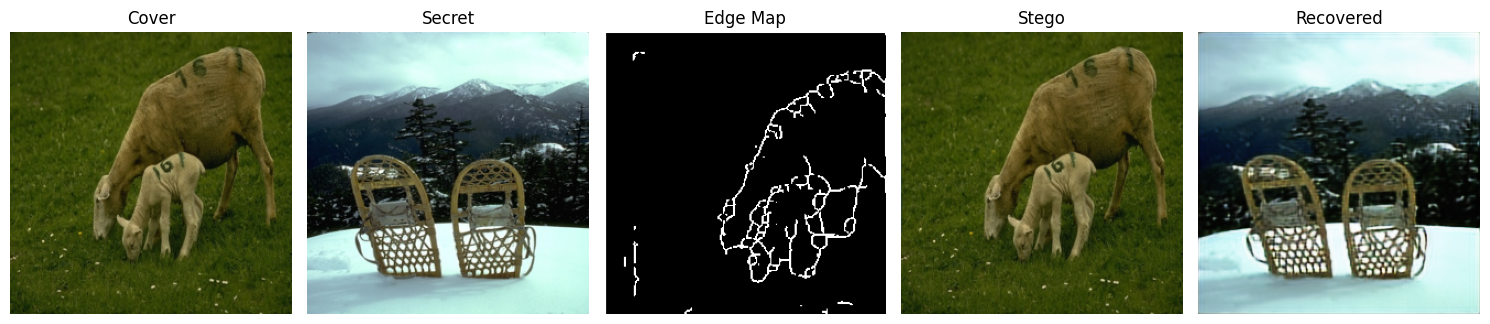

In [ ]:
test_inference(model, dataloader)

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def test_inference(model, cover_path, secret_path, edge_path, rgb_transform=None, edge_transform=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()

    # Load images
    try:
        cover = Image.open(cover_path).convert('RGB')
        secret = Image.open(secret_path).convert('RGB')
        edge = Image.open(edge_path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Failed to load images: {e}\n"
                          f"Cover: {cover_path}\nSecret: {secret_path}\nEdge: {edge_path}")

    # Apply transforms if provided
    if rgb_transform:
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)
        cover = rgb_transform(cover)
        torch.manual_seed(seed)
        secret = rgb_transform(secret)
    if edge_transform:
        torch.manual_seed(seed)
        edge = edge_transform(edge)
    else:
        # Convert edge to tensor if no transform provided
        edge = torch.from_numpy(np.array(edge)).float() / 255.0
        edge = edge.unsqueeze(0)  # Add channel dimension

    # Apply binary threshold to edge map
    edge = (edge > 0.12).float()

    # Add batch dimension and move to device
    cover = cover.unsqueeze(0).to(device)
    secret = secret.unsqueeze(0).to(device)
    edge = edge.unsqueeze(0).to(device) if edge.dim() == 3 else edge.to(device)

    with torch.no_grad():
        # Run model
        stego, recovered_secret = model(cover, secret, edge)

        # Prepare images for visualization
        images = [
            cover[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
            secret[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
            edge[0].cpu().squeeze(),
            stego[0].cpu().permute(1, 2, 0) * 0.5 + 0.5,
            recovered_secret[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
        ]
        titles = ["Cover", "Secret", "Edge Map", "Stego", "Recovered"]

        # Visualize results
        plt.figure(figsize=(15, 5))
        for i in range(len(titles)):
            plt.subplot(1, len(titles), i + 1)
            if i == 2:  # Edge map is grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        return cover, secret, edge, stego, recovered_secret

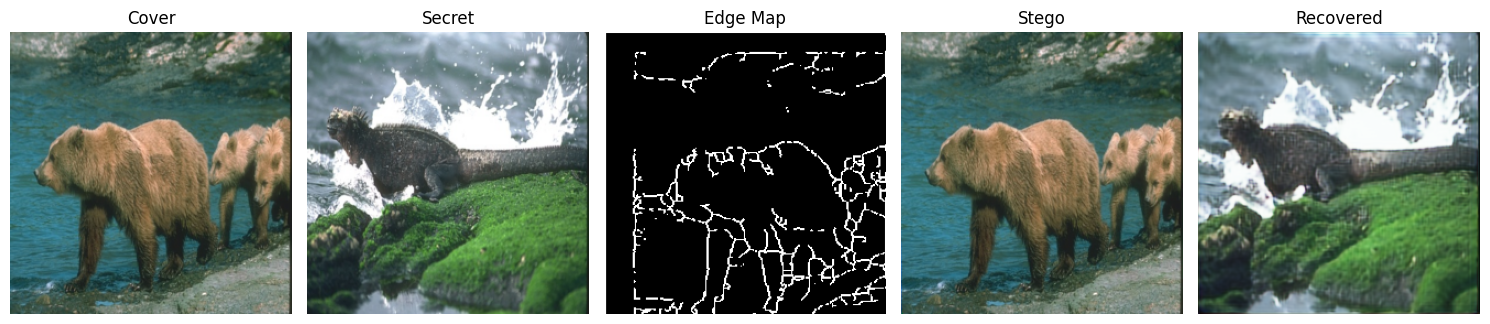

(tensor([[[[-0.1922, -0.1373, -0.0275,  ..., -0.7020, -0.8118, -0.7804],
           [-0.2000, -0.1451, -0.0039,  ..., -0.6471, -0.8118, -0.7725],
           [-0.1294, -0.0824, -0.0039,  ..., -0.6000, -0.7961, -0.7725],
           ...,
           [-0.6941, -0.6392, -0.5843,  ..., -0.3255, -0.6392, -0.6941],
           [-0.6549, -0.6235, -0.5922,  ..., -0.4039, -0.6471, -0.6941],
           [-0.6235, -0.6000, -0.5294,  ..., -0.5216, -0.6627, -0.7098]],
 
          [[-0.0667, -0.0431,  0.0353,  ..., -0.5922, -0.7490, -0.7647],
           [-0.0667, -0.0431,  0.0588,  ..., -0.5373, -0.7490, -0.7569],
           [-0.0039,  0.0196,  0.0745,  ..., -0.4824, -0.7490, -0.7647],
           ...,
           [-0.4745, -0.4196, -0.3882,  ..., -0.3020, -0.6314, -0.6863],
           [-0.4353, -0.4039, -0.3804,  ..., -0.3725, -0.6392, -0.6863],
           [-0.3882, -0.3804, -0.3176,  ..., -0.4824, -0.6471, -0.6941]],
 
          [[-0.2157, -0.1922, -0.1059,  ..., -0.6863, -0.7961, -0.7804],
           [-

In [ ]:
test_inference(model,
               cover_path="/content/drive/MyDrive/image steganography/BSDS500/images/train/100075.jpg",
               secret_path="/content/drive/MyDrive/image steganography/BSDS500/images/test/108041.jpg",
               edge_path="/content/drive/MyDrive/image steganography/data/hed_predictions2/100075.jpg",
               rgb_transform,
               edge_transform,
               device='cuda' if torch.cuda.is_available() else 'cpu')